<a href="https://colab.research.google.com/github/kaburia/NOAA-workshop/blob/main/03_Temperature_Quality_PET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Focus Area 3 — Temperature Quality &amp; Microclimates
**Core Objective**: To demonstrate the advantages of high-resolution temperature data in
capturing microclimates and computing derived metrics like PET, for better assessment of heat-
related risks.

## Extract Temperature data
- GHCN data
- CBAM data
- ERA5 data
<br>

EA: March 2025 heatwave, linking to health impacts.

Use the current location and get the nearest GHCNd weather station and visualise the temperature over the last half a century

Require 2 files
- The Metadata file: TAHMO_Metadata.csv
- The TAHMO data file: TAHMO_data.csv

Metadata file format (Columns):
<!DOCTYPE html>
<html>
<head>
    <title>TAHMO Metadata</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>Latitude</th>
            <th>Longitude</th>
        </tr>
        <tr>
            <td>TA00283</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Data file format (Columns): Temperature / Precipitation data for multiple stations
<html>
<head>
    <title>TAHMO Data</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>TA00283</th>
            <th>TA00284</th>
            <th>TA00285</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

In [132]:
!git clone https://github.com/kaburia/NOAA-workshop.git
!cd NOAA-workshop && pip install -r requirements.txt

Cloning into 'NOAA-workshop'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 164 (delta 14), reused 4 (delta 2), pack-reused 136 (from 1)
Receiving objects: 100% (164/164), 38.43 MiB | 26.90 MiB/s, done.
Resolving deltas: 100% (79/79), done.
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
import os
os.chdir('NOAA-workshop')

In [148]:
#  @title Dependencies point plotting Functions

import random

def plot_temperatures(tmin_df, tavg_df, tmax_df, station_code=None):
    """
    Plots the daily minimum, average, and maximum temperatures for a specified TAHMO station.

    Args:
        tmin_df (pd.DataFrame): DataFrame containing daily minimum temperatures.
        tavg_df (pd.DataFrame): DataFrame containing daily average temperatures.
        tmax_df (pd.DataFrame): DataFrame containing daily maximum temperatures.
        station_code (str, optional): The code of the station to plot. If None, a random station from the DataFrame is plotted.
    """
    if station_code is None:
        station_code = random.choice(tmin_df.columns.tolist())
        print(f"Randomly selected station: {station_code}")
    elif station_code not in tmin_df.columns:
        print(f"Station code {station_code} not found in the data.")
        return

    plt.figure(figsize=(12, 6))
    plt.plot(tmin_df.index, tmin_df[station_code], label='Min Temp', marker='o', linestyle='-')
    plt.plot(tavg_df.index, tavg_df[station_code], label='Avg Temp', marker='o', linestyle='-')
    plt.plot(tmax_df.index, tmax_df[station_code], label='Max Temp', marker='o', linestyle='-')

    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Daily Temperatures for Station {station_code}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [149]:
# @title ERA5 extract data from 1982



import ee
import io
import os
import tempfile
import requests
import datetime
import numpy as np
import xarray as xr
import rasterio
from rasterio.io import MemoryFile
from rasterio.transform import xy as rio_xy

# Authenticate / initialize once (uncomment in interactive runtime)
# ee.Authenticate()
# ee.Initialize()

def era5_yearly_to_inmemory_netcdf(
    variable,
    start_year=1982,
    end_year=None,
    region_ee_geometry=None,
    dataset='ERA5_LAND',   # 'ERA5' or 'ERA5_LAND'
    cadence='monthly',       # 'hourly' or 'daily' or 'monthly'
    scale=None,            # meters (defaults used below)
    crs='EPSG:4326',
    save_local_copy=False, # also save .nc to local disk (path returned)
    local_folder='./',
    max_images_per_year=4000  # safety cutoff
):
    """
    For each year in [start_year, end_year], download the ERA5 images in that year,
    aggregate them according to the specified cadence, build a time-x-y-xarray dataset
    and write a NetCDF file for that year, then return the NetCDF as an in-memory
    BytesIO object.

    Returns:
        dict: { year (int) : { 'nc_bytes': io.BytesIO, 'local_path': str or None } }
    """

    if end_year is None:
        end_year = datetime.datetime.utcnow().year

    # Dataset selection and default scale (meters)
    ds_upper = dataset.upper()
    if ds_upper == 'ERA5_LAND' or ds_upper == 'ERA5-LAND' or ds_upper == 'ERA5LAND':
        coll_hourly = 'ECMWF/ERA5_LAND/HOURLY'
        coll_daily = 'ECMWF/ERA5_LAND/DAILY_AGGR'
        default_scale = 11132
    elif ds_upper == 'ERA5':
        coll_hourly = 'ECMWF/ERA5/HOURLY'
        coll_daily = 'ECMWF/ERA5/DAILY'
        default_scale = 27830
    else:
        raise ValueError("dataset must be 'ERA5' or 'ERA5_LAND'")

    if scale is None:
        scale = default_scale

    if region_ee_geometry is None:
        raise ValueError("region_ee_geometry (an ee.Geometry) is required (keep it small!)")

    # turn region into a geojson / coordinates object for getDownloadURL
    # getInfo() here calls the server once
    region_geojson = region_ee_geometry.getInfo()

    results = {}

    for year in range(start_year, end_year + 1):
        print(f"\n--- Processing year {year} ---")
        start_date_year = f'{year}-01-01'
        end_date_year = f'{year+1}-01-01'

        if cadence == 'hourly':
            coll = ee.ImageCollection(coll_hourly).filterDate(start_date_year, end_date_year).select(variable)
        elif cadence == 'daily':
            coll = ee.ImageCollection(coll_daily).filterDate(start_date_year, end_date_year).select(variable)
        elif cadence == 'monthly':
             # Process month by month for monthly aggregation
            monthly_images = []
            current_month_start = datetime.datetime.strptime(start_date_year, '%Y-%m-%d')
            while current_month_start.year == year:
                next_month_start = (current_month_start.replace(day=1) + datetime.timedelta(days=32)).replace(day=1)
                coll_hourly_month = ee.ImageCollection(coll_hourly).filterDate(current_month_start, next_month_start).select(variable)
                monthly_image = coll_hourly_month.mean() # Aggregate hourly to monthly mean
                monthly_images.append(monthly_image.set('system:time_start', ee.Date(current_month_start)))
                current_month_start = next_month_start
            coll = ee.ImageCollection(monthly_images)
        else:
            raise ValueError("cadence must be 'hourly', 'daily', or 'monthly'")


        try:
            n_images = int(coll.size().getInfo())
        except Exception as e:
            raise RuntimeError(f"Could not fetch collection size for {year}: {e}")

        if n_images == 0:
            print(f"No images found for {year} (variable '{variable}', cadence '{cadence}'). Skipping.")
            continue

        if n_images > max_images_per_year and cadence != 'monthly': # Allow more images for monthly aggregation
             raise RuntimeError(f"Year {year} has {n_images} images > max_images_per_year ({max_images_per_year}). Aborting for safety.")

        print(f"Found {n_images} images for {year}. Downloading each to memory (this may be slow).")

        # Build lists to stack
        img_arrays = []
        times = []
        ref_shape = None
        ref_transform = None
        ref_crs = None

        # Convert collection to server list and iterate
        coll_list = coll.toList(n_images)

        for i in range(n_images):
            ee_img = ee.Image(coll_list.get(i))
            # time string
            try:
                time_start_ms = ee.Date(ee_img.get('system:time_start')).getInfo()['value']
                time_str = datetime.datetime.fromtimestamp(time_start_ms / 1000.0).strftime('%Y-%m-%d')
            except Exception:
                # fallback: use index-based date
                time_str = f'{year}-unknown-{i}'
            print(f"  - image {i+1}/{n_images} date {time_str} ...", end=' ', flush=True)

            # Request a GeoTIFF download URL (format GEO_TIFF to get raw .tif bytes)
            params = {
                'bands': [variable],
                'region': region_geojson,   # geojson-like mapping or coordinates (small)
                'scale': int(scale),
                'format': 'GEO_TIFF',
                'filePerBand': False
            }

            try:
                url = ee_img.getDownloadURL(params)
            except Exception as e:
                raise RuntimeError(f"getDownloadURL failed for {year} image idx {i}: {e}")

            # Download bytes (may be zipped or raw GeoTIFF depending on params; we asked GEO_TIFF)
            r = requests.get(url, timeout=600)
            if r.status_code != 200:
                raise RuntimeError(f"HTTP error {r.status_code} when downloading image: {r.text[:200]}")

            # Load into rasterio MemoryFile
            with MemoryFile(r.content) as mem:
                with mem.open() as src:
                    arr = src.read(1)           # single-band image
                    transform = src.transform
                    crs_src = src.crs
                    h, w = src.height, src.width

            # check shape consistency
            if ref_shape is None:
                ref_shape = (h, w)
                ref_transform = transform
                ref_crs = crs_src
            else:
                if (h, w) != ref_shape:
                    raise RuntimeError(f"Image {i} shape {h,w} differs from first image shape {ref_shape}. Reprojection/resampling not implemented - aborting.")

            img_arrays.append(arr)
            times.append(np.datetime64(time_str))
            print("OK")

        # Stack into ndarray (time, y, x)
        data_stack = np.stack(img_arrays, axis=0)  # shape (time, H, W)
        print(f"Stacked data: {data_stack.shape}")

        # Build coordinate vectors from transform
        height, width = ref_shape
        # x coords (cols)
        xs = np.array([rio_xy(ref_transform, 0, col, offset='center')[0] for col in range(width)])
        # y coords (rows) - note rasterio returns y per (row, col); rows increase downward
        ys = np.array([rio_xy(ref_transform, row, 0, offset='center')[1] for row in range(height)])

        # xarray DataArray
        da = xr.DataArray(
            data_stack,
            dims=('time', 'y', 'x'),
            coords={'time': times, 'y': ys, 'x': xs},
            name=variable
        )

        ds = xr.Dataset({variable: da})
        ds.attrs['source'] = f"GEE {coll_daily} ({dataset})" # Note: still using daily collection ID in source attr
        # Convert region_geojson to a string for NetCDF compatibility
        ds.attrs['region'] = json.dumps(region_geojson)
        ds.attrs['scale_m'] = scale

        # Persist to a temporary netCDF file, then load bytes into memory
        tmpf = tempfile.NamedTemporaryFile(suffix=f"_{variable}_{year}_{cadence}.nc", delete=False)
        tmpf.close()
        try:
            ds.to_netcdf(tmpf.name, engine='netcdf4')
        except Exception as e:
            os.unlink(tmpf.name)
            raise RuntimeError(f"Failed to write NetCDF for year {year}: {e}")

        # Read bytes into memory BytesIO
        with open(tmpf.name, 'rb') as f:
            nc_bytes = f.read()

        # Optionally save a local persistent copy
        local_path = None
        if save_local_copy:
            os.makedirs(local_folder, exist_ok=True)
            local_path = os.path.join(local_folder, f"{variable}_{year}_{cadence}.nc")
            with open(local_path, 'wb') as f:
                f.write(nc_bytes)

        # Cleanup temp file
        os.unlink(tmpf.name)

        results[year] = {'nc_bytes': io.BytesIO(nc_bytes), 'local_path': local_path}

        print(f"Year {year} done: NetCDF in memory ({len(nc_bytes)/1e6:.2f} MB).")

    return results



In [150]:
# @title ERA5 builder
import ee
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors
import math
import datetime
import io
from tqdm import tqdm
from datetime import datetime, timedelta
from IPython.display import HTML, display
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from filter_stations import retreive_data, Filter
import base64
import json
import requests
import datetime
from utils.helpers import get_region_geojson, df_to_xarray



def extract_era5_daily(start_date_str, end_date_str, bbox=None, polygon=None, era5_l=False, aggregate='mean'):
    """
    Extract ERA5 reanalysis data (daily aggregated) from Google Earth Engine for a given bounding box or polygon and time range.
    The extraction is performed on a daily basis by aggregating hourly images (using the mean) for each day.
    For each day, the function retrieves the ERA5 HOURLY images, aggregates them, adds pixel coordinate bands (longitude
    and latitude), and uses sampleRectangle to extract a grid of pixel values. The results for each variable (band) are then
    organized into pandas DataFrames with the following columns:
      - date: The daily timestamp (ISO formatted)
      - latitude: The latitude coordinate of the pixel center
      - longitude: The longitude coordinate of the pixel center
      - value: The aggregated pixel value for that variable

    Args:
        start_date_str (str): Start datetime in ISO format, e.g., '2020-01-01T00:00:00'.
        end_date_str (str): End datetime in ISO format, e.g., '2020-01-02T00:00:00'.
        bbox (list or tuple, optional): Bounding box specified as [minLon, minLat, maxLon, maxLat]. Default is None.
        polygon (list, optional): Polygon specified as a list of coordinate pairs (e.g., [[lon, lat], ...]).
                                  If provided, the polygon geometry will be used instead of the bounding box.
                                  Default is None.
        era5_l (bool, optional): If True, use ERA5_LAND instead of ERA5. Default is False.
        aggregate (str, optional): Aggregation method ('mean' or 'sum' or 'min', or 'max'). Default is 'mean'.

    Returns:
        dict: A dictionary where keys are variable (band) names and values are pandas DataFrames containing
              the daily aggregated data.
    """
    # Convert input datetime strings to Python datetime objects.
    start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%dT%H:%M:%S')
    end_date   = datetime.datetime.strptime(end_date_str, '%Y-%m-%dT%H:%M:%S')

    # Define the geometry: Use polygon if provided, otherwise use bbox.
    if polygon is not None:
        region = ee.Geometry.Polygon(polygon)
    elif bbox is not None:
        region = ee.Geometry.Rectangle(bbox)
    else:
        raise ValueError("Either bbox or polygon must be provided.")

    # Define a scale in meters corresponding approximately to 0.25° (at the equator, 1° ≈ 111320 m).
    scale_m = 27830

    # This dictionary will accumulate extracted records for each variable (band).
    results = {}

    # Loop over each day in the specified time range.
    current = start_date
    while current < end_date:
        next_day = current + datetime.timedelta(days=1)

        # Format the current time window in ISO format.
        t0_str = current.strftime('%Y-%m-%dT%H:%M:%S')
        t1_str = next_day.strftime('%Y-%m-%dT%H:%M:%S')

        print(f"Processing {t0_str} to {t1_str}")

        # If ER5 Land (0.1) or ERA5 (0.25)
        if era5_l:
            # Get the ERA5 Land hourly image collection for the current day.
            collection = ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY') \
                            .filterDate(ee.Date(t0_str), ee.Date(t1_str))
        else:
            # Get the ERA5 hourly image collection for the current day.
            collection = ee.ImageCollection('ECMWF/ERA5/HOURLY') \
                            .filterDate(ee.Date(t0_str), ee.Date(t1_str))

        # Aggregate the hourly images into a single daily image using the mean.
        if aggregate == 'mean':
            image = collection.mean()
        elif aggregate == 'sum':
            image = collection.sum()
        elif aggregate == 'min':
            image = collection.min()
        elif aggregate == 'max':
            image = collection.max()
        else:
            raise ValueError(f"Invalid aggregation method: {aggregate} can either be sum, min, max or mean")

        # Add bands containing the pixel longitude and latitude.
        image = image.addBands(ee.Image.pixelLonLat())

        # Use sampleRectangle to extract a grid of pixel values over the region.
        region_data = image.sampleRectangle(region=region, defaultValue=0).getInfo()

        # The pixel values for each band are in the "properties" dictionary.
        props = region_data['properties']

        # Extract the coordinate arrays from the added pixelLonLat bands.
        lon_array = props['longitude']  # 2D array of longitudes
        lat_array = props['latitude']   # 2D array of latitudes

        # Determine the dimensions of the extracted grid.
        nrows = len(lon_array)
        ncols = len(lon_array[0]) if nrows > 0 else 0

        # Identify the names of the bands that hold ERA5 variables, excluding the coordinate bands.
        band_names = [key for key in props.keys() if key not in ['longitude', 'latitude']]

        # Initialize results lists for each band if not already present.
        for band in band_names:
            if band not in results:
                results[band] = []

        # Loop over each pixel in the grid.
        for i in range(nrows):
            for j in range(ncols):
                pixel_lon = lon_array[i][j]
                pixel_lat = lat_array[i][j]
                # For each ERA5 variable band, extract the pixel value and create a record.
                for band in band_names:
                    pixel_value = props[band][i][j]
                    record = {
                        'date': t0_str,  # daily timestamp as a string
                        'latitude': pixel_lat,
                        'longitude': pixel_lon,
                        'value': pixel_value
                    }
                    results[band].append(record)

        # Advance to the next day.
        current = next_day

    # Convert the accumulated results for each band into pandas DataFrames.
    dataframes = {band: pd.DataFrame(records) for band, records in results.items()}
    return dataframes



In [168]:
# @title Plot stations on a map
import folium

def plot_stations_folium(dataframes, colors=None, wmo=True):
    """
    Plot stations from one or more dataframes on a Folium map.

    Each dataframe must have 'location.latitude' and 'location.longitude' columns.
    'colors' is a list specifying marker colors for each dataframe respectively.
    """
    if colors is None:
        colors = ["blue", "red", "green", "purple", "orange"]

    # Create a base map; you can adjust the initial location/zoom as needed
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Add markers for each dataframe
    for df, color in zip(dataframes, colors):
        for _, row in df.iterrows():
          if wmo:
              folium.Marker(
                  location=[row["lat"], row["lon"]],
                  tooltip=str(row["station"]),   # <--- Pass the tooltip here
                  icon=folium.Icon(color=color)
              ).add_to(m)
          else:
              folium.Marker(
                  location=[row["location.latitude"], row["location.longitude"]],
                  tooltip=str(row["code"]),   # <--- Pass the tooltip here
                  icon=folium.Icon(color=color)
              ).add_to(m)

    return m

In [152]:
# @title Cmpute PET + Stress
import numpy as np

def pet_hargreaves(tmin, tmax, tmean, Ra=15.0):
    dtr = np.maximum(tmax - tmin, 0)
    return 0.0023 * Ra * (tmean + 17.8) * np.sqrt(dtr)

def rmse(a,b): return float(np.sqrt(np.nanmean((np.asarray(a)-np.asarray(b))**2)))


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [144]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import json
import ee
from scipy.stats import pearsonr


In [ ]:
from utils.filter_stations import RetrieveData
from utils.CBAM_helpers import CBAMClient, extract_cbam_data # CBAM helper functions
from utils.plotting import select, scale, plot_xarray_data, plot_xarray_data2, compare_xarray_datasets, compare_xarray_datasets2 # Plotting helper functions



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [138]:
eac_region = [[28.861754, -2.8399383],
 [28.861754, -2.8399383],
 [28.861754, -1.0473752],
 [29.573433, -1.4823178],
 [29.573433, -1.4823178],
 [29.573433, 4.218628],
 [30.8991179, -2.8399383],
 [30.8991179, -1.0473752],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, 5.033420899999999],
 [35.0330489, -1.4823178],
 [35.0330489, 4.218628],
 [41.9068688, -4.724299999999999],
 [41.9068688, 5.033420899999999]]

start_date = "2025-04-01"
end_date = "2025-05-31"

ee.Authenticate()
ee.Initialize(project='leafy-computing-310902')

# get the xmin, xmax, ymin, ymax from eac region
def xmin_ymin_xmax_ymax(polygon):
    lons = [point[0] for point in polygon]
    lats = [point[1] for point in polygon]
    return min(lons), min(lats), max(lons), max(lats)
xmin, ymin, xmax, ymax = xmin_ymin_xmax_ymax(eac_region)
print(xmin, ymin, xmax, ymax)

28.861754 -4.724299999999999 41.9068688 5.033420899999999


We are going to examine the March 2025 heatwave


In [ ]:
# Station comparison
start_date = '2024-03-01'
end_date = '2024-03-31'

### Extract the TAHMO temperature 5 minute data for 2024 and extrat the tmin, tavg and tmax

In [153]:
# Load TAHMO EAC stations previously extracted
eac_metadata = pd.read_csv("/content/drive/MyDrive/Datasets/ground/eac_stations.csv")
eac_metadata = eac_metadata[['code',
                             'location.latitude',
                             'location.longitude']].rename(columns={'location.latitude': 'lat',
                                                                    'location.longitude': 'lon'})

In [155]:
# Load the config file
with open('/content/config (1).json', 'r') as f:
    config = json.load(f)

# Set the api key and secret
api_key = config['apiKey']
api_secret = config['apiSecret']


# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)

In [ ]:
# Get the temperature data for the EAC stations in 5min intervals
eac_temp = rd.multiple_measurements(stations_list=eac_metadata['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['te'],
                                     csv_file = "/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_temp_march_2024",
                                     aggregate='5min'
                                     )

In [ ]:
# Aggregate the values to get the min, mean and max for the day
tahmo_eac_tmin = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='min'
)
tahmo_eac_tavg = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='mean'
)
tahmo_eac_tmax = rd.aggregate_variables(
    eac_temp,
    freq='1D',
    method='max'
)


Randomly selected station: TA00215


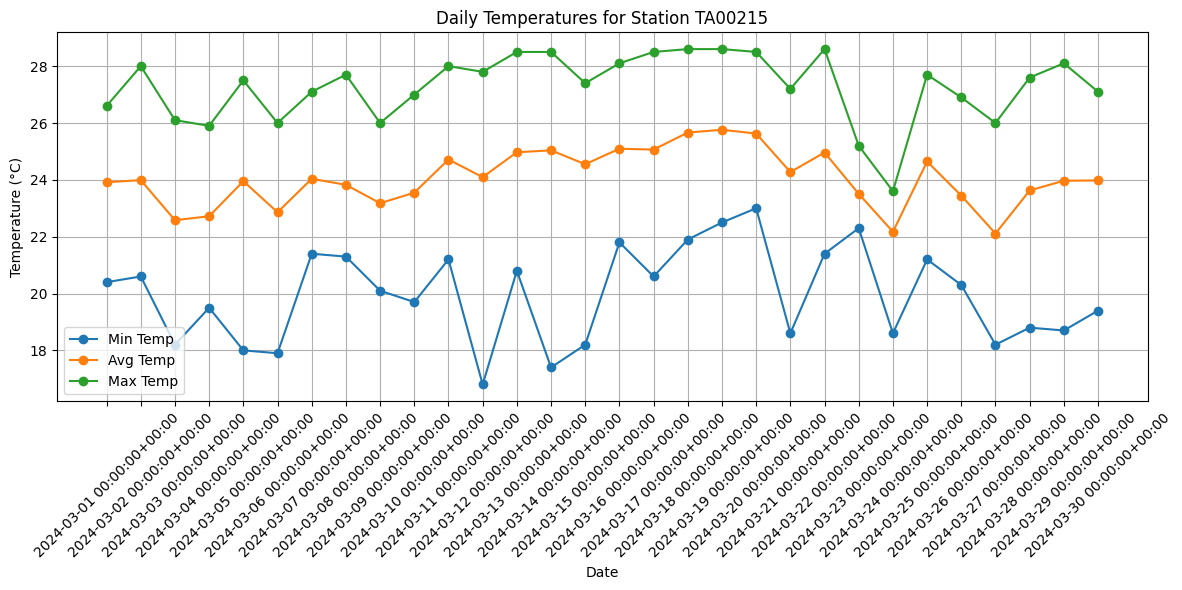

In [ ]:

plot_temperatures(tahmo_eac_tmin, tahmo_eac_tavg, tahmo_eac_tmax)

In [ ]:
# Save the variables
tahmo_eac_tmin.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmin_march_2024.csv", index=True)
tahmo_eac_tavg.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tavg_march_2024.csv", index=True)
tahmo_eac_tmax.to_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmax_march_2024.csv", index=True)

### GHCNd stations
- Available globally

In [ ]:
!git clone https://github.com/scotthosking/get-station-data.git

Cloning into 'get-station-data'...
remote: Enumerating objects: 381, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 381 (delta 54), reused 54 (delta 47), pack-reused 287 (from 1)
Receiving objects: 100% (381/381), 1.06 MiB | 7.78 MiB/s, done.
Resolving deltas: 100% (196/196), done.


In [158]:
import sys

sys.path.append('get-station-data')

from get_station_data import ghcnd
from get_station_data.util import nearest_stn

from utils.GHCN_stations import subset_stations_in_bbox, get_nearest_wmo_station, subset_noaa_stations_by_country # GHCN station helper functions


%matplotlib inline

In [170]:
stn_md = ghcnd.get_stn_metadata()
# stn_md

# Format the data rename lat and lon to latitude and longitude
# stn_md = stn_md.rename(columns={'lat': 'latitude', 'lon': 'longitude'})

In [171]:
wmo_ke_stations = subset_noaa_stations_by_country(stn_md, 'KE')
wmo_ug_stations = subset_noaa_stations_by_country(stn_md, 'UG')
wmo_rw_stations = subset_noaa_stations_by_country(stn_md, 'RW')

# concatenate eac stations
eac_wmo_stations = pd.concat([wmo_ke_stations, wmo_ug_stations, wmo_rw_stations])

In [172]:
plot_stations_folium([wmo_ke_stations, wmo_ug_stations, wmo_rw_stations])

In [177]:
# Get the data
eac_wmo_data = ghcnd.get_data(eac_wmo_stations)

Using 1 CPUs out of 2... 


100%|██████████| 19/19 [00:11<00:00,  1.67it/s]


In [181]:
eac_wmo_data[eac_wmo_data.station == 'KEM00063741']

,station,element,value,mflag,qflag,sflag,date,lon,lat,elev,name
0,KEM00063741,TAVG,17.9,H,,S,1957-01-01,36.75,-1.3,1798.0,NAIROBI/DAGORETTI
1,KEM00063741,TAVG,17.9,H,,S,1957-01-02,36.75,-1.3,1798.0,NAIROBI/DAGORETTI
2,KEM00063741,TAVG,16.3,H,,S,1957-01-03,36.75,-1.3,1798.0,NAIROBI/DAGORETTI
3,KEM00063741,TAVG,15.3,H,,S,1957-01-04,36.75,-1.3,1798.0,NAIROBI/DAGORETTI
4,KEM00063741,TAVG,17.9,H,,S,1957-01-05,36.75,-1.3,1798.0,NAIROBI/DAGORETTI
...,...,...,...,...,...,...,...,...,...,...,...
40189,KEM00063741,TMIN,NaN,,,,2025-08-30,36.75,-1.3,1798.0,NAIROBI/DAGORETTI
40190,KEM00063741,PRCP,NaN,,,,2025-08-31,36.75,-1.3,1798.0,NAIROBI/DAGORETTI
40191,KEM00063741,TAVG,NaN,,,,2025-08-31,36.75,-1.3,1798.0,NAIROBI/DAGORETTI
40192,KEM00063741,TMAX,NaN,,,,2025-08-31,36.75,-1.3,1798.0,NAIROBI/DAGORETTI


In [175]:
# Nairobi coordinates
nairobi_coords = -1.293295, 36.822163
kigali_coords = -1.944559, 30.061947
kampala_coords = 0.315646, 32.581673

In [174]:
# Get the nearest station
nearest_stn(stn_md, nairobi_coords[1], nairobi_coords[0])

,station,lat,lon,elev,name,start_year,end_year
40464,KEM00063741,-1.3,36.75,1798.0,NAIROBI/DAGORETTI,1984.0,2025.0


In [ ]:
# method given coordinates computes the nearest station together with the data
def get_nearest_wmo_station_data(stn_md, eac_wmo_data, lat, lon):
  import haversine as hs
  # get the nearest data
  nearest_station = nearest_stn(stn_md, lon, lat)

  # compute the distance
  distance = hs.haversine((lat, lon), (nearest_station['lat'], nearest_station['lon']))

  # get the data from the station id
  soi = eac_wmo_data[eac_wmo_data.station == nearest_station['station']]

  # Return the distance and the data
  return distance, soi

# write a method to extract tmin, tmax, tvg
def extract_tmin_tmax_tvg(soi):
  gh_tavg = subset_weather_data_by_variable(gh_df, 'TAVG', pivot=True)
  gh_tmin = subset_weather_data_by_variable(gh_df, 'TMIN', pivot=True)
  gh_tmax = subset_weather_data_by_variable(gh_df, 'TMAX', pivot=True)

#### Compare the temperature of TAHMO station/WMO station with the Met Agency data

In [ ]:
# Compare the temperatures

### Extract CBAM temperature data (2012 -2024)

In [ ]:
# Define parameters as shown in the docs
product = 'cbam_historical_analysis'
attribs = ["max_temperature", "min_temperature"]
# start_date = '2012-01-01'
# end_date = '2023-12-31'
eac_bbox = [xmin, ymin, xmax, ymax]
print(eac_bbox)

# Create a client and extract data
client = CBAMClient('config.json')
cbam_data = extract_cbam_data(start_date='2012-01-01', end_date='2024-12-31',
                         attributes=attribs, cbam_client=client, bbox=eac_bbox,
                         output_type='netcdf')


[28.861754, -4.724299999999999, 41.9068688, 5.033420899999999]


### Extract ERA5 temperature data (1982-2025)

In [ ]:
roi = ee.Geometry.Polygon(eac_region)

out = era5_yearly_to_inmemory_netcdf(
    variable='temperature_2m',
    start_year=1982,
    end_year=2024,
    region_ee_geometry=roi,
    dataset='ERA5',        # or 'ERA5_LAND'
    cadence='monthly',
    scale=27830,           # use native-ish scale for ERA5 (meters)
    save_local_copy=False
)

# Access the NetCDF bytes for 2023:
nc_bytesio = out[2023]['nc_bytes']      # io.BytesIO
# To load into xarray directly from memory:
nc_bytesio.seek(0)
ds = xr.open_dataset(nc_bytesio)
print(ds)


## Data Processing

1. Ground (GHCN/TAHMO/your station) vs CBAM/ERA5
2. PET comparison plot (CBAM vs ERA5)
3. Count of heat/agri stress days --- Plot of the heat exchange

#### Load TAHMO data

In [182]:
# Load the tmin, tmax, tavg files
tahmo_eac_tmin = pd.read_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmin_march_2024.csv", index_col=0)
tahmo_eac_tmax = pd.read_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tmax_march_2024.csv", index_col=0)
tahmo_eac_tavg = pd.read_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_tavg_march_2024.csv", index_col=0)


#### Load ERA5 Data

In [184]:
era5_march = xr.open_dataset("/content/drive/Shareddrives/NOAA-workshop/Datasets/reanalysis/era5/era5_temperature_agg_march_2024.nc")
era5_march

<xarray.Dataset> Size: 115kB
Dimensions:          (lat: 11, lon: 14, time: 31)
Coordinates:
  * lat              (lat) float64 88B -4.5 -3.5 -2.5 -1.5 ... 2.5 3.5 4.5 5.5
  * lon              (lon) float64 112B 28.5 29.5 30.5 31.5 ... 39.5 40.5 41.5
  * time             (time) datetime64[ns] 248B 2024-03-01 ... 2024-03-31
Data variables:
    min_temperature  (time, lat, lon) float64 38kB ...
    avg_temperature  (time, lat, lon) float64 38kB ...
    max_temperature  (time, lat, lon) float64 38kB ...

In [ ]:
era5_monthly = xr.open_dataset("/content/drive/Shareddrives/NOAA-workshop/Datasets/reanalysis/era5/era5_temperature_monthly_1982_2024_combined.nc")
# rename x and y to latitude and longitude
era5_monthly = era5_monthly.rename({'x': 'longitude', 'y': 'latitude'})

# Subtract 273.15 to convert from Kelvin to degrees celsius
era5_monthly['temperature_2m'] = era5_monthly['temperature_2m'] - 273.15

# In time column strip the day and just have YYYY-MM
era5_monthly['time'] = era5_monthly['time'].dt.strftime('%Y-%m')

In [ ]:
era5_monthly

<xarray.Dataset> Size: 4MB
Dimensions:         (time: 516, latitude: 40, longitude: 53)
Coordinates:
  * time            (time) object 4kB '1982-01' '1982-02' ... '2024-12'
  * latitude        (latitude) float64 320B 5.125 4.875 4.625 ... -4.375 -4.625
  * longitude       (longitude) float64 424B 28.88 29.13 29.38 ... 41.63 41.88
Data variables:
    temperature_2m  (time, latitude, longitude) float32 4MB 27.52 ... 27.94
Attributes:
    source:   GEE ECMWF/ERA5/DAILY (ERA5)
    region:   {"type": "Polygon", "coordinates": [[[28.861754, -2.8399383], [...
    scale_m:  27830

In [ ]:
plot_xarray_data2(
    xarray_ds=era5_monthly,
    fig_title="ERA5 Temperature Analysis in East Africa",
    columns=["temperature_2m"],
    plot_size=7,
    bbox=[xmin, ymin, xmax, ymax],
)

#### Load CBAM Data

In [ ]:
# Data from 2018-2024
cbam_eac = xr.open_dataset('/content/drive/Shareddrives/NOAA-workshop/Datasets/reanalysis/CBAM_temp2018_2024.nc')

# Agreegate the data from daiy to monthly
cbam_eac_monthly = cbam_eac.resample(time='M').mean()

cbam_eac_monthly